In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

C:\Users\Javier\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Javier\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Javier\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\U

In [19]:
from pix2pix.utils.dataset import remove_portion, normalize
from pix2pix.utils.model import Pix2Pix
import matplotlib.pyplot as plt
%matplotlib inline
from yolo.detect import prepare_detector
from yolo.yolov3.utils import draw_outputs
from yolo.yolov3.dataset import transform_images
import cv2
import numpy as np
import math
import os

In [3]:
input = 'Paris_2.png'
classes = './yolo/data/coco.names'
class_names = [c.strip() for c in open(classes).readlines()]
N_people = 5
HEIGHT = 256
WIDTH = 256

# Funciones generales

In [4]:
def read_image(input):
    img = tf.io.read_file(input)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    
    return img

# Funciones YOLO 

In [5]:
def prepare_image_yolo(img, size=416):
    img = tf.expand_dims(img, 0)
    img = transform_images(img, size)
    
    return img

def cut_result(output):
    '''
    This function reshapes the tf tensors.
    '''
    boxes, scores, classes, nums = output[0], output[1], output[2], output[3]
    
    amount = nums.numpy()[0]
    boxes = boxes[0,:amount,:]
    scores = scores[0,:amount]
    classes = classes[0, :amount]
    
    return [boxes, scores, classes, nums]

def expand_box(x1y1, x2y2, coeff_area=1.05):
    coeff_length = math.sqrt(coeff_area)
    
    x1y1 = (int(x1y1[0] * (2-coeff_length)), int(x1y1[1] * (2-coeff_length)))
    x2y2 = (int(x2y2[0] * coeff_length), int(x2y2[1] * coeff_length))
    
    return x1y1, x2y2

def get_person_image(img, box, expand=False):
    wh = np.flip(image.shape[0:2])
    # Posiciones de la caja. x1y1 es abajo a la izquierda y x2y2 es arriba a la derecha
    x1y1 = tuple((np.array(box[0:2]) * wh).astype(np.int32))
    x2y2 = tuple((np.array(box[2:4]) * wh).astype(np.int32))
    
    if expand:
        x1y1, x2y2 = expand_box(x1y1, x2y2)

    box_width = x2y2[1] - x1y1[1]
    box_height = x2y2[0] - x1y1[0]

    box_border_1 = (x1y1[0] - box_height // 2, x1y1[1] - box_width // 2)
    box_border_2 = (x2y2[0] + box_height // 2, x2y2[1] + box_width // 2)
    
    im_cut = image[box_border_1[1]:box_border_2[1], box_border_1[0]:box_border_2[0], :]
    im_cut = tf.image.resize(im_cut, [HEIGHT, WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    #return im_cut, box_border_1, box_border_2
    return im_cut, x1y1, x2y2

# Funciones Pix2Pix

In [14]:
def generate_fake(img, model):
    # img = tf.image.resize(img, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    img = normalize(img)
    fake = remove_portion(img, 256, 256)
    fake = tf.expand_dims(fake, 0)
    
    return model.generator(fake)[0]

def insert_into_image(img_real, img_fake, x1y1, x2y2):
    img_fake = img_fake[WIDTH // 4:WIDTH * 3 // 4, HEIGHT // 4:HEIGHT * 3 // 4,:]
    x1y1 = (max(0, x1y1[0]), max(0, x1y1[1]))
    x2y2 = (min(img_real.shape[1], x2y2[0]), min(img_real.shape[0], x2y2[1]))
    
    box_width = x2y2[1] - x1y1[1]
    box_height = x2y2[0] - x1y1[0]
    img_fake_resized = tf.image.resize(img_fake, [box_width, box_height], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    img_fake = img_fake.numpy()
    
    img_real[x1y1[1]:x2y2[1], x1y1[0]:x2y2[0], :] = img_fake_resized[:]
    
    return img_real

def insert_blocks(img_real, blocks, coords):
    img_numpy = img_real.numpy()
    for block, coord in zip(blocks, coords):
        x1y1 = coord[0]
        x2y2 = coord[1]
        img_numpy = insert_into_image(img_numpy, block, x1y1, x2y2)
        
    return img_numpy

def create_new_image(img_real, output_yolo):
    img_fake = normalize(img_real)
    boxes, scores, classes, nums = output_yolo[0], output_yolo[1], output_yolo[2], output_yolo[3]
    blocks = []
    coords = []

    for i in range(nums[0]):
        if classes[i].numpy() == 0:
            im_cut, x1y1, x2y2 = get_person_image(image, boxes[i])
            fake_block = generate_fake(im_cut, p2p)
            
            blocks.append(fake_block)
            coords.append((x1y1, x2y2))

    new = insert_blocks(img_fake, blocks, coords)
    return new

### Prepare networks

In [28]:
yolo = prepare_detector()

In [29]:
p2p = Pix2Pix(mode='try', checkpoint_dir='pix2pix/checkpoint/')

### Read image 

In [30]:
image = read_image('input/remove_people/2.png')

### YOLO

In [31]:
image_yolo = prepare_image_yolo(image)
output_yolo = yolo(image_yolo)
output_yolo = cut_result(output_yolo)

### Pix2Pix

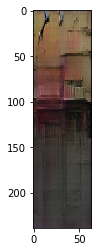

In [32]:
final_image = create_new_image(image, output_yolo)

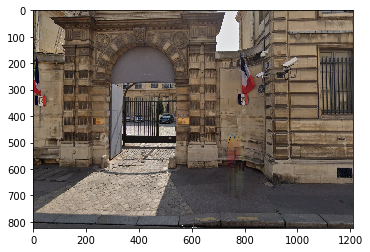

In [33]:
plt.imshow(final_image*0.5+0.5)

In [17]:
plt.imsave('G.png',final_image*0.5+0.5)

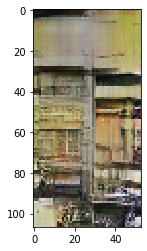

In [34]:
input_folder = 'input/remove_people/'
for file in os.listdir('input/remove_people/'):
    input = input_folder + file
    image = read_image(input)
    image_yolo = prepare_image_yolo(image)
    output_yolo = yolo(image_yolo)
    output_yolo = cut_result(output_yolo)
    final_image = create_new_image(image, output_yolo)
    plt.imsave(f'output/{file}', final_image*0.5+0.5)